<a href="https://colab.research.google.com/github/theyloac/MachineLearning_Text_Classification/blob/main/MachineLearningTextClassification_reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install asyncpraw
!pip install config

In [31]:
# Packages

import re
import praw
import config
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## Load Data

In [ ]:
# Configure and authenticate with Reddit API using your credentials
api_reddit = praw.Reddit(client_id="xxx", client_secret="xxx", password="xxx", user_agent="xxx", username="xxx")

# Define subreddits from which to scrape posts
assuntos = ['datascience', 'machinelearning', 'physics', 'astrology', 'conspiracy']

# Initialize list to hold text data
data = []

# Initialize list to hold label indices corresponding to subreddits
labels = []

# Lambda function to remove non-alphanumeric characters and count remaining characters in post text
char_count = lambda post: len(re.sub('\W|\d', '', post.selftext))

# Lambda function to check if post text has at least 100 characters
mask = lambda post: char_count(post) >= 100

# Loop through each subreddit, fetch and filter posts, and append them to the data and labels lists
for i, assunto in enumerate(assuntos):
    # Access the subreddit
    subreddit_data = api_reddit.subreddit(assunto).new(limit=1000)
    # Filter posts using the mask and extract their text
    posts = [post.selftext for post in filter(mask, subreddit_data)]
    # Extend the data list with these posts
    data.extend(posts)
    # Append corresponding index to labels list for each post
    labels.extend([i] * len(posts))
    # Output the number of posts fetched and a snippet of one post
    print(f"Número of posts about r/{assunto}: {len(posts)}", f"\nSample of one post: {posts[0][:600]}...\n", "_" * 80 + '\n')


## Split data

In [ ]:
# Define the proportion of data to set aside for testing
TEST_SIZE = .2
# Set a random seed for reproducibility
RANDOM_STATE = 0

# Split the data and labels into training and testing sets
X_treino, X_teste, y_treino, y_teste = train_test_split(data, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
# Print the number of samples in the test set
print(f"{len(y_teste)} test samples.")


# Preprocessing Pipeline

In [35]:
# Define a pattern to identify unwanted characters in the text
pattern = r'\W|\d|http.*\s+|www.*\s+'

# Define a preprocessor that removes unwanted characters from text
preprocessor = lambda text: re.sub(pattern, ' ', text)

# Configure the TF-IDF vectorizer with the custom preprocessor
vectorizer = TfidfVectorizer(preprocessor=preprocessor, stop_words='english', min_df=1)

# Set up the Truncated SVD to reduce the dimensionality of the feature set
decomposition = TruncatedSVD(n_components=1000, n_iter=30)

# Combine the vectorizer and SVD into a preprocessing pipeline
pipeline = [('tfidf', vectorizer), ('svd', decomposition)]


# Model Creation

In [36]:
# Initialize a K-Nearest Neighbors model with 4 neighbors
modelo_1 = KNeighborsClassifier(n_neighbors=4)

# Initialize a Random Forest model with a random state for reproducibility
modelo_2 = RandomForestClassifier(random_state=RANDOM_STATE)

# Initialize a Logistic Regression model with cross-validation
modelo_3 = LogisticRegressionCV(cv=3, random_state=RANDOM_STATE)

# Combine all models into a list for later processing
all_models = [("KNN", modelo_1), ("RandomForest", modelo_2), ("LogReg", modelo_3)]



# Train and Evaluate Models

In [37]:
# Initialize an empty list to store results
resultados = []

# Loop through each model, fit it on the training data, and evaluate it on the test data
for name, modelo in all_models:
    # Create a pipeline combining the preprocessing pipeline with the current model
    pipe = Pipeline(pipeline + [(name, modelo)])
    # Train the model
    pipe.fit(X_treino, y_treino)
    # Predict the labels of the test set
    y_pred = pipe.predict(X_teste)
    # Generate a classification report
    report = classification_report(y_teste, y_pred)
    # Print the classification report
    print(f"{name} report\n", report)
    # Store the model and its evaluation results in the list
    resultados.append([modelo, {'model': name, 'predictions': y_pred, 'report': report}])


KNN report
               precision    recall  f1-score   support

           0       0.65      0.67      0.66        86
           1       0.67      0.86      0.76       168
           2       0.77      0.55      0.64        42
           3       0.90      0.84      0.87       102
           4       0.90      0.66      0.76       124

    accuracy                           0.75       522
   macro avg       0.78      0.72      0.74       522
weighted avg       0.77      0.75      0.75       522

RandomForest report
               precision    recall  f1-score   support

           0       0.92      0.42      0.58        86
           1       0.68      0.98      0.80       168
           2       1.00      0.52      0.69        42
           3       0.92      0.86      0.89       102
           4       0.86      0.86      0.86       124

    accuracy                           0.80       522
   macro avg       0.88      0.73      0.76       522
weighted avg       0.84      0.80      0.79 

# Visualize Results

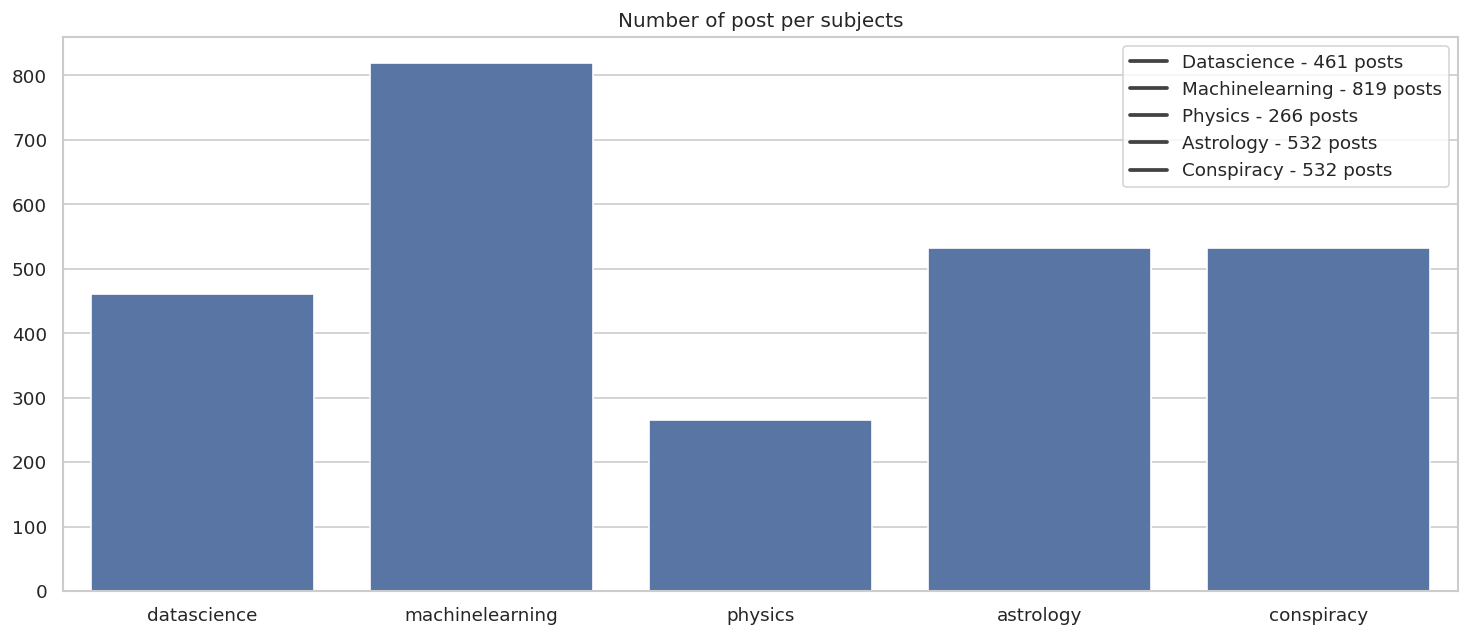

In [38]:
# Calculate the count of posts per subreddit
_, counts = np.unique(labels, return_counts=True)

# Set the seaborn theme for visualizations
sns.set_theme(style="whitegrid")

# Create a bar plot to visualize the number of posts per subreddit
plt.figure(figsize=(15, 6), dpi=120)
plt.title("Number of post per subjects")
sns.barplot(x=assuntos, y=counts)

# Add a legend to the plot
plt.legend([' '.join([f.title(), f"- {c} posts"]) for f, c in zip(assuntos, counts)])
plt.show()


# Plot Confusion Matrix

Classification report
               precision    recall  f1-score   support

           0       0.65      0.67      0.66        86
           1       0.67      0.86      0.76       168
           2       0.77      0.55      0.64        42
           3       0.90      0.84      0.87       102
           4       0.90      0.66      0.76       124

    accuracy                           0.75       522
   macro avg       0.78      0.72      0.74       522
weighted avg       0.77      0.75      0.75       522



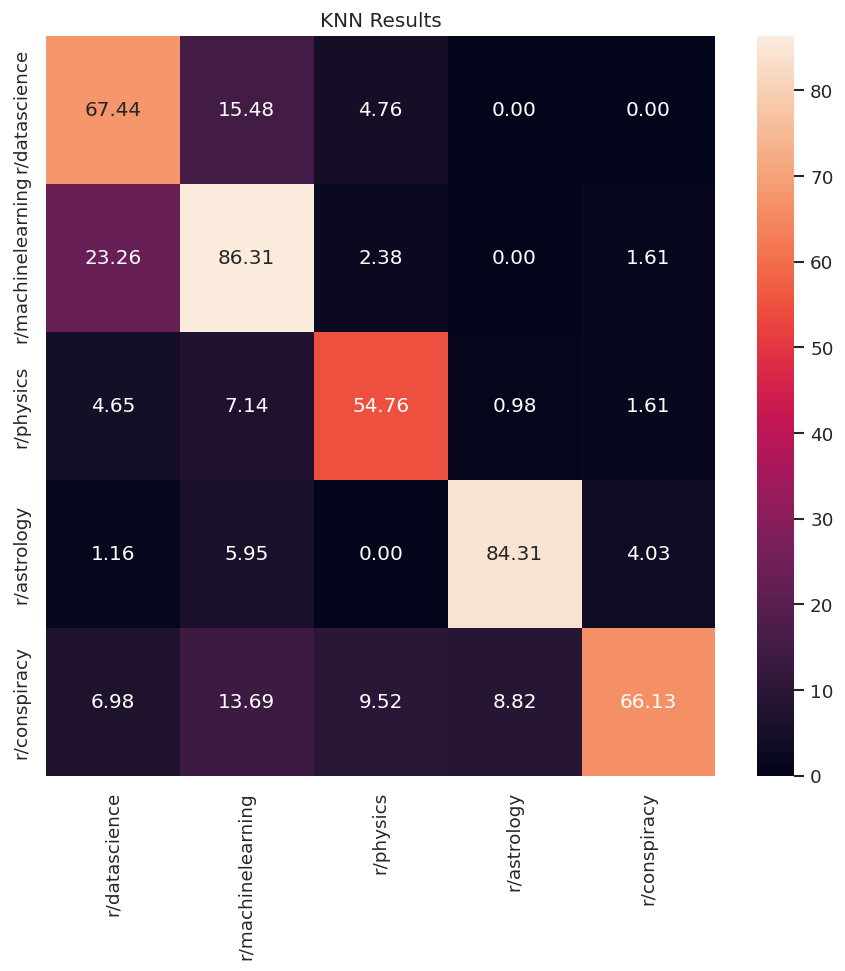

Classification report
               precision    recall  f1-score   support

           0       0.92      0.42      0.58        86
           1       0.68      0.98      0.80       168
           2       1.00      0.52      0.69        42
           3       0.92      0.86      0.89       102
           4       0.86      0.86      0.86       124

    accuracy                           0.80       522
   macro avg       0.88      0.73      0.76       522
weighted avg       0.84      0.80      0.79       522



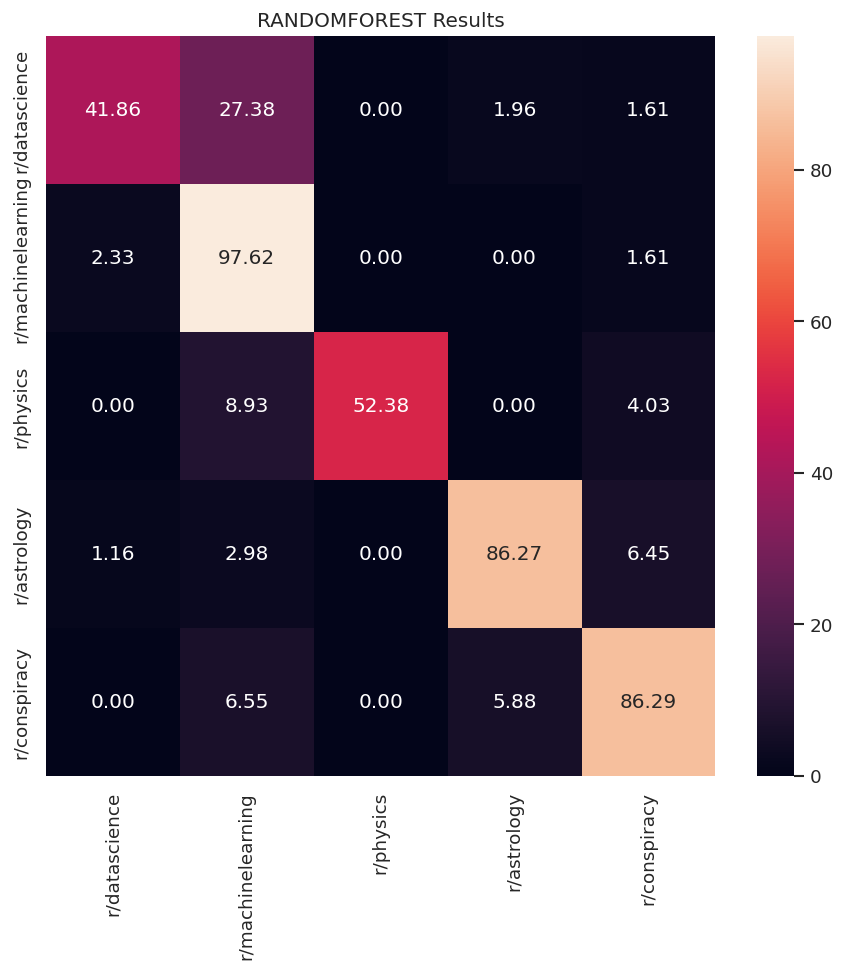

Classification report
               precision    recall  f1-score   support

           0       0.84      0.63      0.72        86
           1       0.80      0.92      0.86       168
           2       0.88      0.71      0.79        42
           3       0.95      0.93      0.94       102
           4       0.90      0.96      0.93       124

    accuracy                           0.87       522
   macro avg       0.88      0.83      0.85       522
weighted avg       0.87      0.87      0.86       522



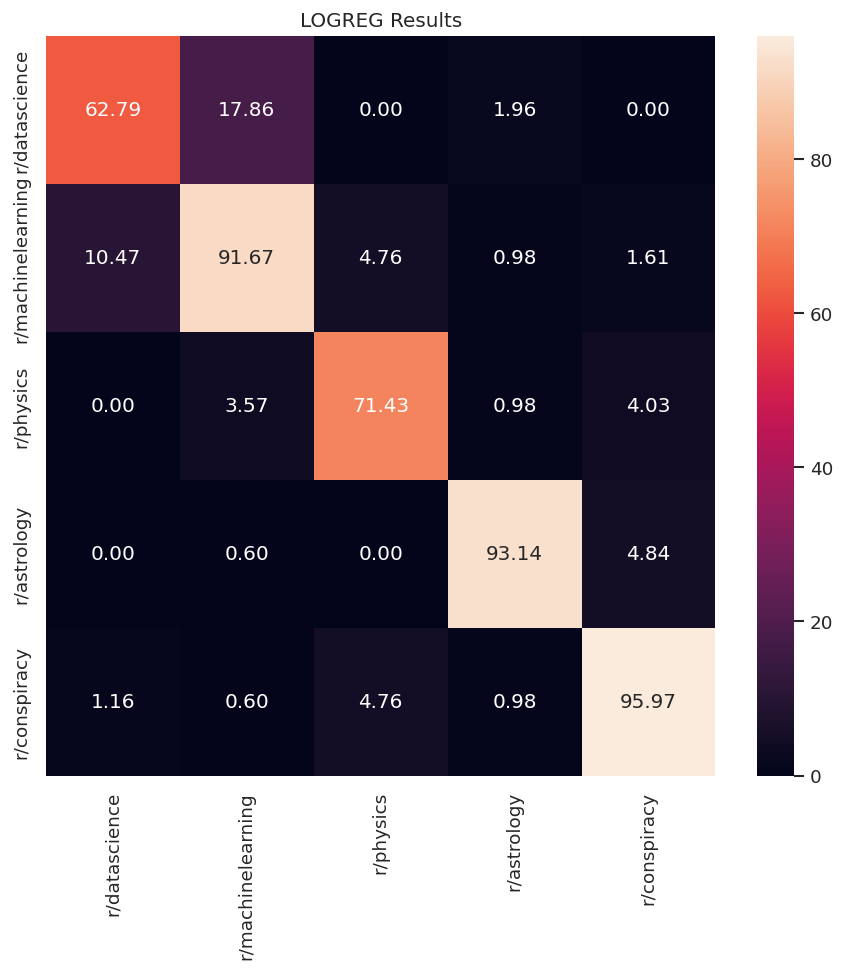

In [40]:
# Function to display a confusion matrix for a given result
def plot_confusion(result):
    # Print the classification report
    print("Classification report\n", result['report'])

    # Extract predicted labels
    y_pred = result['predictions']

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_teste, y_pred)

    # Normalize the confusion matrix
    _, test_counts = np.unique(y_teste, return_counts=True)
    conf_matrix_percent = conf_matrix / test_counts.transpose() * 100

    # Plot the normalized confusion matrix
    plt.figure(figsize=(9, 8), dpi=120)
    plt.title(result['model'].upper() + " Results")
    plt.xlabel("Real Valor")
    plt.ylabel("Previsão do Modelo")
    ticklabels = [f"r/{sub}" for sub in assuntos]
    sns.heatmap(data=conf_matrix_percent, xticklabels=ticklabels, yticklabels=ticklabels, annot=True, fmt='.2f')
    plt.show()

# Execute the function for each model's results
for result in resultados:
    plot_confusion(result[1])
